# 06 Custom Kernels and Mean Functions

_[Estimated execution time: 1 min]_

In this tutorial we show how custom kernels can be trained with this toolkit as well as how we can train a mean function for our data set. We create an artificial data set, we show how to define a trainable mean function and how to seperate training of the mean function and the kernel.

In [1]:
import mogptk
import numpy as np

Let's create a function that is periodical and add a polynomial. In this case we choose a sinusoidal with unit frequency and a second-degree polynomial $2.0x - 0.2x^2$.

Remark that loading a `Data` object using `mogptk.LoadFunction` allows us to know the "true" signal to which we add a random variance. This is useful for plotting and also for calculating the "true" prediction error.

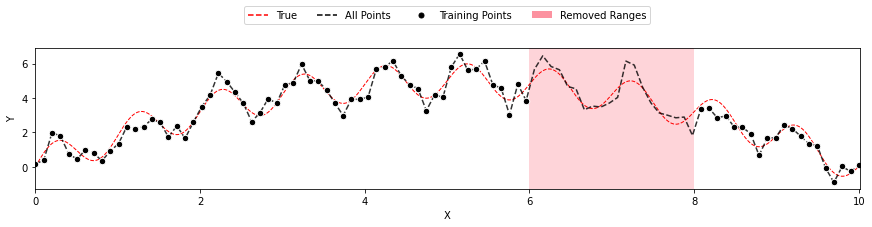

In [2]:
f = lambda x: np.sin(x*2.0*np.pi) + 2*x - 0.2*x**2
data = mogptk.LoadFunction(f, start=0.0, end=10.0, n=100, var=0.5)
data.remove_range(start=6.0, end=8.0)
data.plot();

In order to make a trainable mean function where the parameters are automatically picked up by [`model.train`](https://games-uchile.github.io/mogptk/model.html#mogptk.model.Model.train), we need to create a new class and derive from [`mogptk.gpr.Mean`](https://games-uchile.github.io/mogptk/gpr/mean.html#mogptk.gpr.mean.Mean). In `__init__` we need to call the base class' initializer and then add parameters by assigning instantiations of [`mogptk.gpr.Parameter`](https://games-uchile.github.io/mogptk/gpr/parameter.html#mogptk.gpr.parameter.Parameter) to the class' properties.

The `__call__` function is called to evaluate the mean function and gets passed an `X` of shape `(data points,input dims)` and should returns the Y values of shape `(datapoints,)`. Make sure to "call" your parameters before using: `coefs = self.coefs()`!

In [3]:
class Mean(mogptk.gpr.Mean):
    def __init__(self):
        super(Mean, self).__init__()        
        self.coefficients = mogptk.gpr.Parameter([0.0, 0.0, 0.0])
    
    def __call__(self, X):
        coefs = self.coefficients()
        return coefs[0] + coefs[1]*X[:,1] + coefs[2]*X[:,1]**2

We initialize our mean function, create a periodic kernel, and initialize our model. See all implemented [single output](https://games-uchile.github.io/mogptk/gpr/singleoutput.html) and [multi output](https://games-uchile.github.io/mogptk/gpr/multioutput.html) kernels. Note that we need to create an [`IndependentMultiOutputKernel`](https://games-uchile.github.io/mogptk/gpr/multioutput.html#mogptk.gpr.multioutput.IndependentMultiOutputKernel) to handle the multi-output nature of MOGPTK, even though in this case we have only one channel.

In this case, the random initialization of the parameters of the periodic kernel may give poor results. Setting reasonable values allows training to properly optimize the kernel.

In [4]:
mean = Mean()
kernel = mogptk.gpr.PeriodicKernel(input_dims=1)
mo_kernel = mogptk.gpr.IndependentMultiOutputKernel(kernel)
model = mogptk.Model(data, mo_kernel, mean=mean, name="Periodic")

# initialize kernel parameters to reasonable values
kernel.l.assign(1.0)
kernel.p.assign(1.0)

We will first only train the mean function, then the kernel, and then both the mean function and the kernel. Note that we can set `trainable` for kernels, means, and individual parameters to enable or disable training.


Start Adam:
    0/100  loss=   244.356  error=   1.44719
    1/100  loss=   538.855  error=   3.51565
    2/100  loss=   211.226  error=   1.61282
    3/100  loss=   352.101  error=  0.743285
    4/100  loss=   396.891  error=  0.787755
    5/100  loss=   268.758  error=  0.739997
    6/100  loss=   187.714  error=   1.26818
    7/100  loss=   226.411  error=   2.10975
    8/100  loss=   281.825  error=   2.51744
    9/100  loss=   262.607  error=   2.41226
   10/100  loss=   199.708  error=   1.93033
   11/100  loss=   163.853  error=   1.27531
   12/100  loss=   179.461  error=  0.758032
   13/100  loss=    208.98  error=  0.648286
   14/100  loss=    208.16  error=  0.628245
   15/100  loss=   177.389  error=  0.672195
   16/100  loss=   149.121  error=   0.89529
   17/100  loss=     146.8  error=   1.33367
   18/100  loss=    162.49  error=   1.65522
   19/100  loss=   170.773  error=    1.7635
   20/100  loss=   159.611  error=   1.64046
   21/100  loss=   140.438  error=   1.340

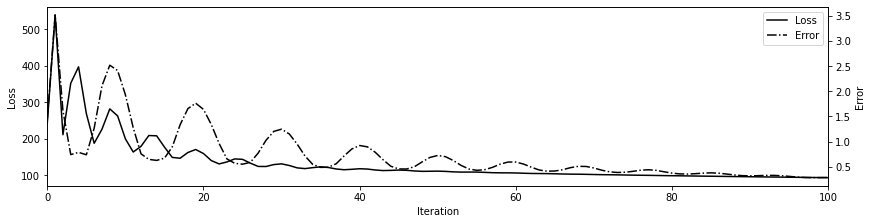

In [5]:
mean.trainable = True
kernel.trainable = False
model.train(method='Adam', lr=0.1, iters=100, plot=True, error='MAE');


Start Adam:
    0/100  loss=   93.6935  error=  0.289012
    1/100  loss=   93.5299  error=  0.287232
    2/100  loss=   93.1128  error=  0.283236
    3/100  loss=   92.8285  error=  0.285361
    4/100  loss=   92.6125  error=  0.286396
    5/100  loss=   92.3088  error=  0.284942
    6/100  loss=   91.9866  error=  0.282321
    7/100  loss=   91.7248  error=   0.28156
    8/100  loss=   91.4872  error=  0.281361
    9/100  loss=   91.2055  error=  0.281359
   10/100  loss=   90.9062  error=  0.281532
   11/100  loss=   90.6389  error=  0.281838
   12/100  loss=    90.395  error=  0.282584
   13/100  loss=    90.134  error=  0.283021
   14/100  loss=   89.8531  error=  0.283122
   15/100  loss=   89.5829  error=  0.282989
   16/100  loss=    89.336  error=  0.282856
   17/100  loss=    89.088  error=  0.283023
   18/100  loss=   88.8229  error=   0.28359
   19/100  loss=   88.5594  error=  0.284376
   20/100  loss=   88.3134  error=  0.285107
   21/100  loss=   88.0721  error=  0.2855

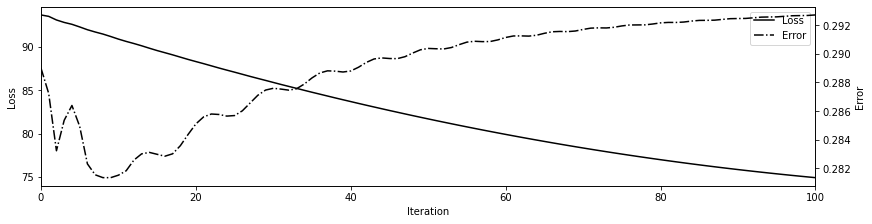

In [6]:
mean.trainable = False
kernel.trainable = True
model.train(method='Adam', lr=0.1, iters=100, plot=True, error='MAE');


Start Adam:
    0/100  loss=   74.9161  error=  0.292713
    1/100  loss=   1200.17  error=   2.01864
    2/100  loss=   147.029  error=  0.339045
    3/100  loss=   310.425  error=   1.32604
    4/100  loss=   712.527  error=   2.01035
    5/100  loss=   564.799  error=   1.79768
    6/100  loss=   224.287  error=   1.10988
    7/100  loss=    76.865  error=  0.265772
    8/100  loss=   193.965  error=  0.517989
    9/100  loss=   360.437  error=  0.922289
   10/100  loss=   372.647  error=  0.954287
   11/100  loss=   243.504  error=  0.660902
   12/100  loss=   109.868  error=  0.224462
   13/100  loss=   78.3109  error=  0.384957
   14/100  loss=   145.493  error=   0.84681
   15/100  loss=   221.208  error=   1.10858
   16/100  loss=   227.348  error=   1.12557
   17/100  loss=   166.013  error=  0.923377
   18/100  loss=   97.7322  error=  0.574925
   19/100  loss=   77.2267  error=  0.224994
   20/100  loss=   108.389  error=  0.255579
   21/100  loss=   149.178  error=   0.405

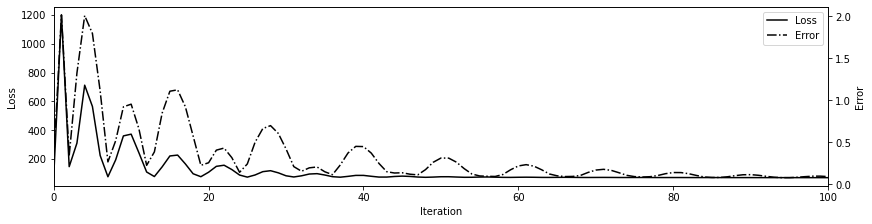

In [7]:
mean.trainable = True
kernel.trainable = True
model.train(method='Adam', lr=0.1, iters=100, plot=True, error='MAE');

,MAE,MAPE,RMSE
Name,,,
Periodic,0.090337,2.009664,0.113061


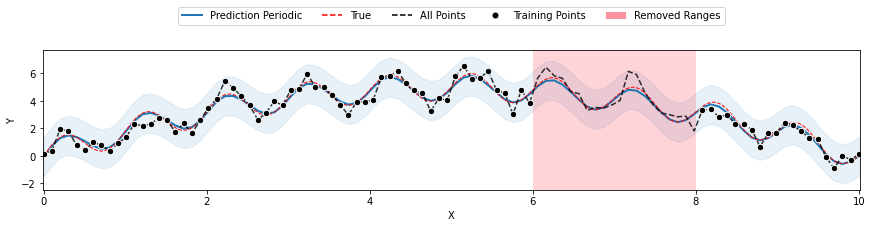

In [8]:
model.predict()
data.plot();

mogptk.error(model, disp=True)

The trained parameters for the coefficients are close to the used values for creating the data set (`[0.0, 2.0, -0.2]`). Also note that the `IMO.noise` parameter is (usually) close to `0.5`. There are two `noise` parameters, one for the entire model and one for each channel of [`IndependentMultiOutputKernel`](https://games-uchile.github.io/mogptk/gpr/multioutput.html#mogptk.gpr.multioutput.IndependentMultiOutputKernel) (IMO). The latter allows training different noises per channel which makes the model-wide noise redundant, thus it is fixed to zero.

In [9]:
model.print_parameters()

Name,Range,Value
IMO.noise,"[1e-08, ∞)",[0.47993218]
IMO[0].Periodic.l,"[1e-08, ∞)",[0.52770795]
IMO[0].Periodic.p,"[1e-08, ∞)",[0.996847]
IMO[0].Periodic.sigma,"[1e-08, ∞)",[0.98673442]
Mean.coefficients,"(-∞, ∞)",[ 0.05953011 1.97191331 -0.19875812]
variance,fixed,0.0
